In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

<AxesSubplot:xlabel='date'>

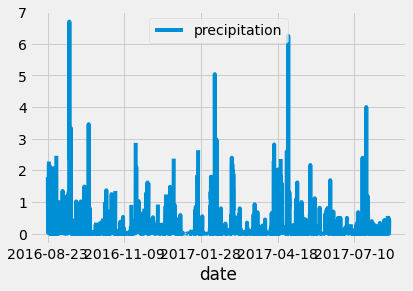

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
#Starting from the last data point in the database. 
prev_year = dt.date(2017, 8, 23)
# Calculate the date one year from the last date in data set.
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
results = []
results = session.query(Measurement.date, Measurement.prcp)
#print(results.all())
# Save the query results as a Pandas DataFrame and set the index to the date column
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year)
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()

#print(results)
df = pd.DataFrame(results, columns=['date','precipitation'])
df.set_index(df['date'], inplace=True)
#print(df)
df = df.sort_index()
#print(df.to_string(index=False))

# Use Pandas Plotting with Matplotlib to plot the data
df.plot()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# How many stations are available in this dataset?
session.query()
session.query(func.count(Station.station)).all()

[(9)]

In [15]:
# What are the most active stations?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station)
#add order by also, left column is station id with the right being the counts for each station- 
#showing us which station is most active
session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query()
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [17]:
#query for temp observations
results = session.query(Measurement.tobs).\
filter(Measurement.station == 'USC00519281').\
filter(Measurement.date >= prev_year).all()
#print(results)
df = pd.DataFrame(results, columns=['tobs'])
print(df)


     tobs
0    77.0
1    77.0
2    80.0
3    80.0
4    75.0
..    ...
347  77.0
348  77.0
349  76.0
350  76.0
351  79.0

[352 rows x 1 columns]


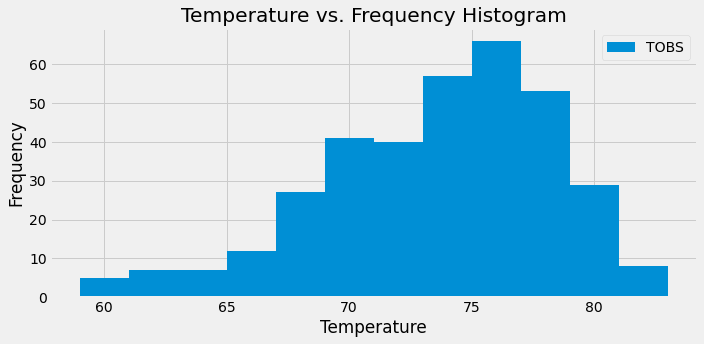

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = session.query(Measurement.tobs).\
    filter(Measurement.date >= prev_year).\
    filter(Measurement.station == "USC00519281").\
    order_by(Measurement.date).all()

# Save the Query Results as a Pandas DataFrame
tobs_data_df = pd.DataFrame(tobs_data, columns=["TOBS"])

# Plot the Results as a Histogram with `bins=12`
tobs_data_df.plot.hist(bins=12, title="Temperature vs. Frequency Histogram", figsize=(10,5))
plt.xlabel("Temperature")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig("temperature_vs_frequency.png")
plt.show()

In [23]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVG, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

In [24]:
my_trip = calc_temps("2017-03-14", "2017-03-28")
my_trip

[(65.0, 73.12222222222222, 80.0)]

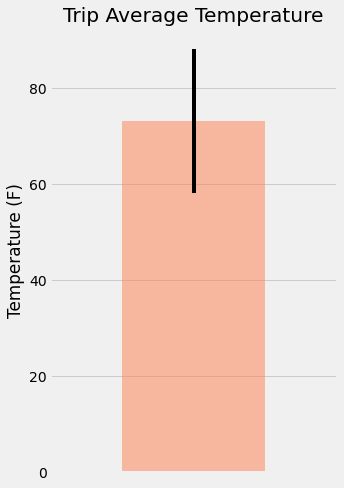

In [26]:

# Load the Results as a Pandas DataFrame
my_trip_df = pd.DataFrame(my_trip, columns=["TMIN", "TAVG", "TMAX"])

# Plot the min, avg, and max Temperatures from the Previous Query as a Bar Chart
# Use "Trip Average Temperature" as the Title
# Use the Average Temperature for the y Value
# Use the Peak-to-Peak (max-min) Value as the y Error Bar (yerr)
my_trip_df.plot.bar(y="TAVG", yerr=(my_trip_df["TMAX"] - my_trip_df["TMIN"]), 
                    title="Trip Average Temperature", color="coral", 
                    alpha=0.5, figsize=(5,7), legend=None)
plt.xticks([])
plt.ylabel("Temperature (F)")
plt.tight_layout()
plt.savefig("trip_average_temperature.png")
plt.show()


# Challenge